# Loading the libraries

In [1]:
import numpy as np
import time
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Preparing the dataset

In [2]:
#fetch the mnist dataset
x, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
print(x.shape,y.shape)

(70000, 784) (70000,)


In [3]:
#x_n = x.to_numpy()
x_n = x
#y_n = y.to_numpy()
y_n = y

In [4]:
y_n = y_n.astype('int') #convert output to integers 0-9
x_norm = x_n/255.0 #normalise input data
x_train, x_val, y_train, y_val = train_test_split(x_norm, y_n, test_size=0.1, random_state=42) #split the data into train and validation
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)

x_train = x_train.T #take the transpose of the training data m*784 -> 784*m
x_val = x_val.T #take the transpose of the test data m*784 -> 784*m
print(x_train.shape, x_val.shape)

(63000, 784) (7000, 784) (63000,) (7000,)
(784, 63000) (784, 7000)


# Defining the functions(GENERAL)

## Parameter initialization

In [5]:
def params_init(seed=2):

  np.random.seed(seed)
  W1 = np.random.rand(20,784) - 0.5
  b1 = np.random.rand(20,1) - 0.5
  W2 = np.random.rand(10,20) - 0.5 
  b2 = np.random.rand(10,1) - 0.5 
  print("Params Initialised")

  return (W1, b1, W2, b2)

## Other generic functions egs-loss

In [6]:

def predictions(A):
  #argmax returns the index of maximum value, we will feed the sigmoid output to this function 
  return np.argmax(A,0)


def accuracy(A,Y):
  #this will compare the predicted output to the ground truth
  return np.sum(A == Y)/(Y.shape[0])*100

In [7]:
def relu(x):
   return np.maximum(x,0)


def softmax(Z):
  #return np.exp(Z) / np.sum(np.exp(Z),0)
  Z = Z-np.max(Z, axis=0)
  return np.exp(Z) / np.sum(np.exp(Z),0)


def relu_d(x):
  return x>0

def one_hot_encoding(y):
  shape = (y.shape[0], 10)
  one_hot = np.zeros(shape)
  rows = np.arange(y.size)
  one_hot[rows, y] = 1
  return one_hot.T

def crossEntropy(y,y_pre):
  loss=-np.sum(np.multiply(y, np.log(y_pre)), axis = 0)
  return loss

## Forward pass

In [8]:
def forward(x_train, W1, b1, W2, b2):
  #print("Entered FP")
  Z1 = np.matmul(W1,x_train) + b1 #W1 is 50*784, x_train is 748*m, Z1 is 50*m
  A1 = relu(Z1)

  Z2 = np.matmul(W2,A1) + b2
  A2 = softmax(Z2)
  

  return Z1, A1, Z2, A2

## Param update

In [9]:
def param_update(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):

  #updates the parameters based on backpropogation

  W1 = W1 - lr*dW1
  b1 = b1 - lr*(db1.reshape(b1.shape))
  W2 = W2 - lr*dW2
  b2 = b2 - lr*(db2.reshape(b2.shape))


  return W1, b1, W2, b2

# Back propagation

In [10]:
def backprop(Z1, A1, Z2, A2, W1, W2, X, y):
  m = y.shape[0] #m is the number of training examples
  Y = one_hot_encoding(y)

  dZ2 = (A2 - Y)
  
  dW2 = 1/m*np.matmul(dZ2,A1.T)

  db2 = 1/m*np.sum(dZ2, axis=1)

  dZ1 = np.matmul(W2.T, dZ2)*relu_d(Z1) #W2 is 10*50, dZ2 = 10*m, dZ1 = 50*m

  dW1 = 1/m*np.matmul(dZ1,X.T) #shape of dZ1 is 50*m, X is 784*m, dW1 = 50*784

  db1 = 1/m*np.sum(dZ1, axis=1) #db1 is 50*1


  return dW1, db1, dW2, db2

In [39]:
def batch_grad_descent(X,Y,iter, lr, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []

  weightsDict = {}

  mu = 1
  sigma = 0.4

  W1, b1, W2, b2 = params_init()
  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)
  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0




    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      Z1, A1, Z2, A2 = forward(X1, W1, b1, W2, b2) 

      dW1, db1, dW2, db2 = backprop(Z1, A1, Z2, A2, W1, W2, X1, Y1)


      W1, b1, W2, b2 = param_update(W1, b1, W2, b2,  dW1, db1, dW2, db2,  lr = lr)

    if (i+1)%(print_op) == 0:
      print(f'Iteration: {i + 1}')

      #obtain training loss
      _, _, _,  A2_train = forward(X, W1, b1, W2, b2)
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train), Y)
      train_acc.append(train_score)
      print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _,   A2_val = forward(x_val, W1, b1, W2, b2)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val), y_val)
      val_acc.append(val_score)
      print(f'Val accuracy: {val_score}')

      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')
      if (i+1)%4==0:
        plt.figure()
        plt.subplot(2,2 ,1)
        plt.hist(W1.flatten(), bins = 30)
        plt.subplot(2,2 ,2)
        plt.hist(W2.flatten(), bins = 30)
        plt.subplot(2,2, 3)
        plt.hist(b1.flatten(), bins = 30)
        plt.subplot(2,2, 4)
        plt.hist(b2.flatten(), bins = 30)

  return train_acc, val_acc


## Adding variabilty

### Generic functions related to variability

In [12]:
#helps in rounding to the nearest integer multiples of the chosen 'step' value!
#add clipping here
# def roundArbitrary(weightArray, step):
#   weightArrayDiv = weightArray / step
#   weightArrayDiv = np.round(weightArrayDiv)
#   return weightArrayDiv*step
def roundArbitrary(weightArray, step, wRange):#updates function with clipping
    #wRange is added for the clipping component 

    weightArrayDiv = np.clip(weightArray, a_min = -wRange, a_max = wRange)
    weightArrayDiv = weightArrayDiv / step
    weightArrayDiv = np.round(weightArrayDiv)
    return weightArrayDiv*step

In [13]:
def getVth(mu, sigma, shape):
  #last dimension represents the binary rep for each weight
  print(shape)
  return np.random.normal(loc=mu, scale=sigma, size=shape) #each bit is represented by an sram so we need those many vth values for each mosfet in this set

In [78]:
def initMosParam(shape, mu, sigma, vDD, precision, ratio):
    #modelling both Ion and Ioff  = I0*exp(Vgs-Vth/(eta*kB*T)),
    dim1, dim2 = shape
    sizeI = (dim1, dim2, precision)
    I0On = 1e+06
    I0Off = I0On/ratio
    #eta = 
    #kB = 1.3806452e10-23
    #T = 300
    VT = 0.026*1.5#should be eqaul to eta x kB x T

    #Vth = getVth(mu, sigma, sizeI)#get the array of Vth values 
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)

    #iOn = ((vDD - Vth)**2)*I0On#scaling the current according to Ioff values arbitraryfor now!!
    iOn = I0On * np.exp((0 - Vth)/(VT))
    #iOn = I0On * np.ones_like(Vth)



    #iOnNominal = 1e-06*(vDD**2 - (2*vDD*mu) + (sigma**2  + mu**2))
    iOnNominal = np.sum(iOn)/(dim1*dim2*precision)
    Vth = np.random.normal(loc=mu, scale=sigma, size = sizeI)
    #iOff = np.random.uniform(low=0, high=1e-5, size = sizeI)#no negative value ~BP seems to be affected by this
    #iOff = (1/100)*iOn
    iOff = I0Off * np.exp((0 - Vth)/(VT))
    #iOff = I0Off * np.ones_like(Vth)
    print(f"Ion/Ioff = {iOnNominal/(np.sum(iOff)/(dim1*dim2*precision))}")
    return (iOn, iOnNominal, iOff)

In [17]:
def weightTransformWithVariability(weightArray, currents, precision, step, discreteSteps, wRange):
  dim1, dim2 = weightArray.shape
  sizeI = (dim1, dim2, precision)

  #clippedWeightIndexArray = np.digitize(np.abs(weightArray), discreteSteps) #finds the index value of the weights
  #updating the above to the actual round function.
  clippedWeightIndexArray = (roundArbitrary(weightArray, step, wRange)/step).astype(np.int64)
  clippedWeightIndexArray = np.abs(clippedWeightIndexArray)

  #vDD = 5
  #mu = 0.7#mean of the distribution
  #sigma = 0.00001
  #! work with sigma/mu
  
  iOn, iOnNominal, iOff = currents

  
  analogWeightArray = np.zeros_like(weightArray, dtype=float)

  for bitLevel in range(precision):
    analogWeightArray +=  np.where(np.bitwise_and(clippedWeightIndexArray, 2**bitLevel)>=1, iOn[:, :, bitLevel], iOff[:, :, bitLevel]) * (2**bitLevel)

  
  analogWeightArray  = np.multiply(np.sign(weightArray), analogWeightArray)

  weightWithVariability = (analogWeightArray/iOnNominal)*step
  return weightWithVariability

In [79]:
def batchGDCompOCUp(X,Y,iter, lrBP, mu, sigma, vDD, precision, step, discreteSteps, wRange, ratio, print_op=1):

  # print("Entered Grad Descent")
  #performs minibatch grad descent for given iterations and learning rate
  n = Y.shape[0]
  train_acc = []
  val_acc = []
  sum_weights = []
  train_loss = []
  val_loss = []
  w1Sim = []
  b1Sim = []
  w2Sim = []
  b2Sim = []
  w3Sim = []
  b3Sim = []
  W1comp = []

  W1, b1, W2, b2 = params_init(2)

  W1bp, b1bp, W2bp, b2bp= W1.copy(), b1.copy(), W2.copy(), b2.copy()
  #W1bp, b1bp, W2bp, b2bp, W3bp, b3bp =params_init()
  W1bp = roundArbitrary(W1bp, step, wRange)#weights have to maintained as their digitized versions
  b1bp = roundArbitrary(b1bp, step, wRange)
  W2bp = roundArbitrary(W2bp, step, wRange)
  b2bp = roundArbitrary(b2bp, step, wRange)
  


  W1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, ratio)
  b1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, ratio)
  W2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, ratio)
  b2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, ratio)



  dW1Currents = initMosParam((20, 784), mu, sigma, vDD, precision, ratio)
  db1Currents = initMosParam((20, 1), mu, sigma, vDD, precision, ratio)
  dW2Currents = initMosParam((10, 20) ,mu, sigma, vDD, precision, ratio)
  db2Currents = initMosParam((10, 1), mu, sigma, vDD, precision, ratio)

  #print(W1)
  #gaussian_W1, gaussian_b1, gaussian_W2, gaussian_b2, gaussian_W3, gaussian_b3, gaussian_W4, gaussian_b4, gaussian_W5, gaussian_b5 = Gaussian_init (mu, sigma)



  for i in range(iter): #loop over 
    train_loss_score = 0
    val_loss_score = 0

    #computing the cosine similarity between the weights at eacj epoch
    # w1Sim.append(cosine_similarity(W1bp.reshape(1,-1), W1np.reshape(1,-1))[0][0])
    # b1Sim.append(cosine_similarity(b1bp.reshape(1,-1), b1np.reshape(1,-1))[0][0])
    # w2Sim.append(cosine_similarity(W2bp.reshape(1,-1), W2np.reshape(1,-1))[0][0])
    # b2Sim.append(cosine_similarity(b2bp.reshape(1,-1), b2np.reshape(1,-1))[0][0])
    # w3Sim.append(cosine_similarity(W3bp.reshape(1,-1), W3np.reshape(1,-1))[0][0])
    # b3Sim.append(cosine_similarity(b3bp.reshape(1,-1), b3np.reshape(1,-1))[0][0])

    #print(cosine_similarity(W1bp.reshape(1,-1), W1wp.reshape(1,-1))[0][0])
    for j in range(100): #loop over batches
      # print("Entered for loops in grad descent")
      #total training samples = 63000, batch size = 630
      X1, Y1 = shuffle(X[:, j*630: (j+1)*630].T,Y[j*630: (j+1)*630]) #shuffle each batch
      X1 = X1.T #take transpose to match the sizes

      #doing the back propagation for the same data set sample

      W1varocbp = weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange)
      b1varocbp = weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange)
      W2varocbp = weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange)
      b2varocbp = weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange)

      Z1, A1, Z2, A2 = forward(X1, W1varocbp, b1varocbp, W2varocbp,b2varocbp) 
      print(f"BP Iter {i} -> sub iter {j} : {round(accuracy(predictions(A2), Y1),3)}", end = "\r", flush = True)
      #print(f"Main iter: {i} Sub iter : {j}\n")
      dW1bp, db1bp, dW2bp, db2bp = backprop(Z1, A1, Z2, A2, W1varocbp, W2varocbp, X1, Y1)
      #print(f"iter in iter{j}")


      dW1roundbp = roundArbitrary(dW1bp, step, wRange)#weights have to maintained as their digitized versions
      db1roundbp = roundArbitrary(db1bp, step, wRange)
      dW2roundbp = roundArbitrary(dW2bp, step, wRange)
      db2roundbp = roundArbitrary(db2bp, step, wRange)


      W1bp, b1bp, W2bp, b2bp = param_update(W1bp, b1bp, W2bp, b2bp, dW1roundbp, db1roundbp, dW2roundbp, db2roundbp,  lr = lrBP)
      #plt.plot(dW1np.flatten(), dW1bp.flatten(), '.')
      #plt.xlabel("Weight updates from Node perturbation")
      #plt.ylabel("Weight updates from Back prop")
      #plt.show()


    #lrNP = lrNP*np.exp(-0.1)
    #lrBP = lrBP*np.exp(-0.1)

    if (i+1)%(print_op) == 0:
      #print(f'\nIteration: {i + 1}')

      #_, _, _, A2_train = forward(X, weightTransformWithVariability(W1wp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1wp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2wp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2wp, b2Currents, precision, step, discreteSteps, wRange))
      _, _, _, A2_train_bp = forward(X, weightTransformWithVariability(W1bp, W1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b1bp, b1Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(W2bp, W2Currents, precision, step, discreteSteps, wRange), weightTransformWithVariability(b2bp, b2Currents, precision, step, discreteSteps, wRange))
      #for i in range(0, Y.shape[0]):
       # train_loss_score = train_loss_score + (-1*(np.log(A5_train[Y[i], i])))
      #train_loss.append(train_loss_score)
      #print(f'Train Loss: {train_loss_score}')

      #obtain training accuracy
      train_score = accuracy(predictions(A2_train_bp), Y)
      train_acc.append(accuracy(predictions(A2_train_bp), Y))
      #print(f'Train accuracy: {train_score}')

      ##obtain validation loss
      _, _, _, A2_val_bp = forward(x_val, W1bp, b1bp, W2bp, b2bp)
      #for i in range(0, y_val.shape[0]):
       # val_loss_score = val_loss_score + (-1*(np.log(A5_val[y_val[i], i]))) 
      #val_loss.append(val_loss_score)
      #print(f'Validation Loss: {val_loss_score}')

      ##obtain validation accuracy
      val_score = accuracy(predictions(A2_val_bp), y_val)
      val_acc.append(accuracy(predictions(A2_val_bp), y_val))
      #print(f'Val accuracy: {val_score}')
      print(f"Iteration: {i + 1}::Train accuracy: {round(train_score, 3)}::Val accuracy: {round(val_score, 3)}:#########################:Train Acc BP::{round(accuracy(predictions(A2_train_bp), Y), 3)} Val Acc BP::{round(accuracy(predictions(A2_val_bp), y_val), 3)}")


      #obtain the sum of weights and append to the sum array
      #sum_w = np.sum(abs(W1)) + np.sum(abs(W2)) + np.sum(abs(W3)) + np.sum(abs(W4)) + np.sum(abs(W5)) + np.sum(abs(b1)) + np.sum(abs(b2)) + np.sum(abs(b3))  + np.sum(abs(b4)) + np.sum(abs(b5))
      #sum_weights.append(sum_w)
      #print(f'Sum of weights: {sum_w}')

  return train_acc, val_acc, train_loss, val_loss, sum_weights

In [80]:
iter=10
lrBP=1
pert=0.01
mu = 0.7
sigma = 0.1
vDD = 5
precision = 16#setting the precision value of the calculations
wRange =  1
noOfLevels = 2**precision - 1 #no of levels of quantization
#step = round(wRange/noOfLevels, precision)
step =  wRange/noOfLevels#step size of each of the step after quantization
#discreteSteps = [round(step*i, precision) for i in range(0, noOfLevels)] #storing the values of the steps
discreteSteps = [step*i for i in range(0, noOfLevels)] #storing the values of the steps

In [82]:
Sigma = [0.1, 0.01, 0.001, 0.0001]
OnOffRatio = [1, 10, 100, 1000, 10000]
AccDic = {}
for ratio in OnOffRatio:
    trainAccBP = []
    for sigma in Sigma:
        train_acc, val_acc, _, _, _ = batchGDCompOCUp(x_train, y_train,iter, lrBP, mu, sigma, vDD, precision, step, discreteSteps, wRange, ratio, print_op=1)
        trainAccBP.append(train_acc)
    AccDic[f"{ratio}"] = trainAccBP

Params Initialised
Ion/Ioff = 1.0321681334767772
Ion/Ioff = 0.5098342319103409
Ion/Ioff = 0.9439758774042487
Ion/Ioff = 2.3191013249029115
Ion/Ioff = 0.9857352974933645
Ion/Ioff = 0.8264933710648411
Ion/Ioff = 1.3752284311681708
Ion/Ioff = 1.4476355265337084
Iteration: 1::Train accuracy: 11.352::Val accuracy: 11.429:#########################:Train Acc BP::11.352 Val Acc BP::11.429
Iteration: 2::Train accuracy: 11.313::Val accuracy: 11.429:#########################:Train Acc BP::11.313 Val Acc BP::11.429
Iteration: 3::Train accuracy: 13.502::Val accuracy: 11.429:#########################:Train Acc BP::13.502 Val Acc BP::11.429
Iteration: 4::Train accuracy: 18.217::Val accuracy: 15.029:#########################:Train Acc BP::18.217 Val Acc BP::15.029
Iteration: 5::Train accuracy: 18.095::Val accuracy: 19.829:#########################:Train Acc BP::18.095 Val Acc BP::19.829
Iteration: 6::Train accuracy: 17.594::Val accuracy: 20.743:#########################:Train Acc BP::17.594 Val Acc BP

Params Initialised
Iteration: 1
Train accuracy: 88.65714285714286
Val accuracy: 88.55714285714285
Iteration: 2
Train accuracy: 91.21904761904761
Val accuracy: 90.91428571428571
Iteration: 3
Train accuracy: 92.66666666666666
Val accuracy: 92.31428571428572
Iteration: 4
Train accuracy: 93.34126984126983
Val accuracy: 92.74285714285713
Iteration: 5
Train accuracy: 93.88095238095238
Val accuracy: 93.04285714285714
Iteration: 6
Train accuracy: 94.30634920634921
Val accuracy: 93.34285714285714
Iteration: 7
Train accuracy: 94.60952380952381
Val accuracy: 93.71428571428572
Iteration: 8
Train accuracy: 94.85555555555555
Val accuracy: 93.91428571428571
Iteration: 9
Train accuracy: 95.06349206349206
Val accuracy: 94.21428571428572
Iteration: 10
Train accuracy: 95.22539682539683
Val accuracy: 94.38571428571429


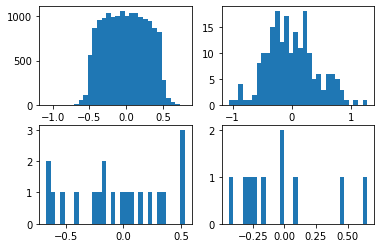

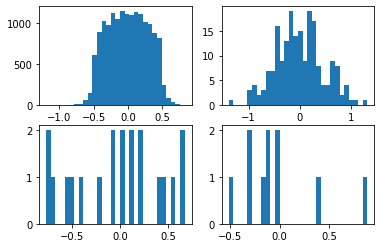

In [58]:
tP, vP = batch_grad_descent(x_train,y_train,iter, lrBP, print_op=1)

Ion/Ioff = 997.7479072416049
Ion/Ioff = 999.9729372561579
Ion/Ioff = 1000.0148016004304
Ion/Ioff = 1000.000483539619


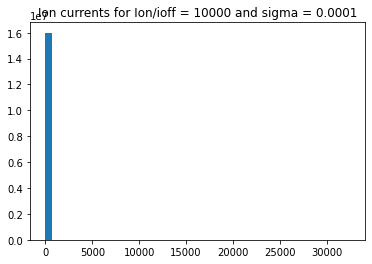

In [97]:
plt.figure()
for sigma in Sigma:
    plt.hist(initMosParam((1000, 1000), mu, sigma, vDD, precision, 1000)[0].flatten(), bins = 50);
    plt.title(f"Ion currents for Ion/ioff = {ratio} and sigma = {sigma}")

Ion/Ioff = 999.9921452945179
Ion/Ioff = 999.9931748857116
Ion/Ioff = 999.9993052041268


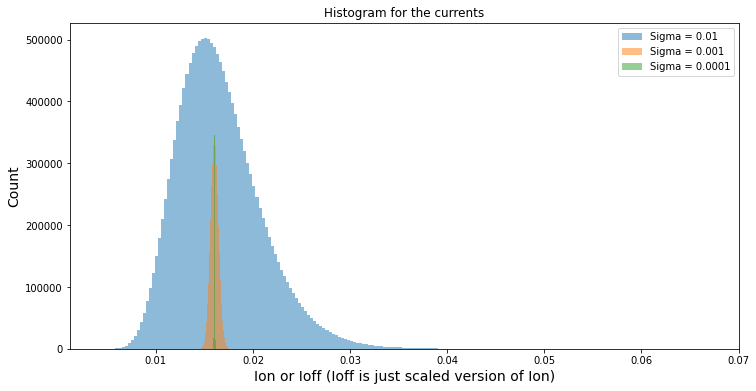

In [106]:
plt.figure(figsize=(12,6))
plt.hist(initMosParam((1000, 1000), mu, Sigma[1], vDD, precision, 1000)[0].flatten(), bins=200, alpha=0.5, label=f"Sigma = {Sigma[1]}")
plt.hist(initMosParam((1000, 1000), mu, Sigma[2], vDD, precision, 1000)[0].flatten(), bins=200, alpha=0.5, label=f"Sigma = {Sigma[2]}")
plt.hist(initMosParam((1000, 1000), mu, Sigma[3], vDD, precision, 1000)[0].flatten(), bins=200, alpha=0.5, label=f"Sigma = {Sigma[3]}")
plt.xlabel("Ion or Ioff (Ioff is just scaled version of Ion)", size=14)
plt.ylabel("Count", size=14)
plt.title("Histogram for the currents")
plt.legend(loc='upper right')

In [107]:
for sigma in Sigma:
    data = initMosParam((10000, 1000), mu, sigma, vDD, precision, 1000)[0].flatten()
    print(f"For sigma = {sigma}, Mean = {np.mean(data)} and std dev = {np.std(data)}")

Ion/Ioff = 1000.0498157621536
For sigma = 0.1, Mean = 0.4295804678502584 and std dev = 11.220511881516392
Ion/Ioff = 1000.0226708501667
For sigma = 0.01, Mean = 0.01656730246872554 and std dev = 0.0043187311195533986
Ion/Ioff = 1000.0059308888219
For sigma = 0.001, Mean = 0.016036707172623496 and std dev = 0.00041124321883527476
Ion/Ioff = 1000.0006949087643
For sigma = 0.0001, Mean = 0.01603143549409843 and std dev = 4.110759821526257e-05


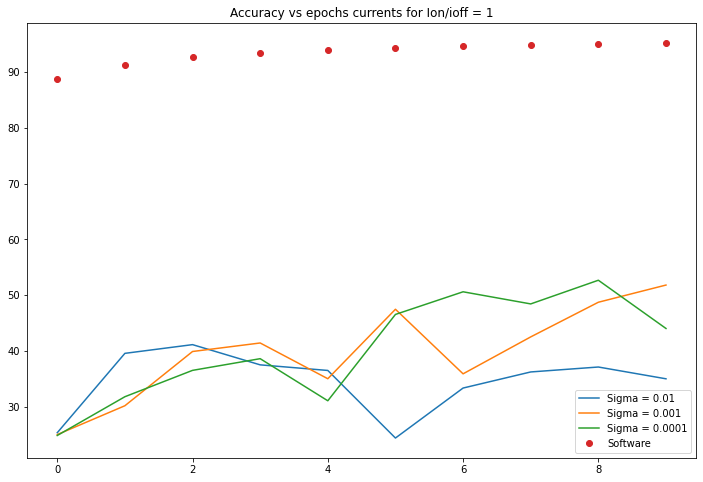

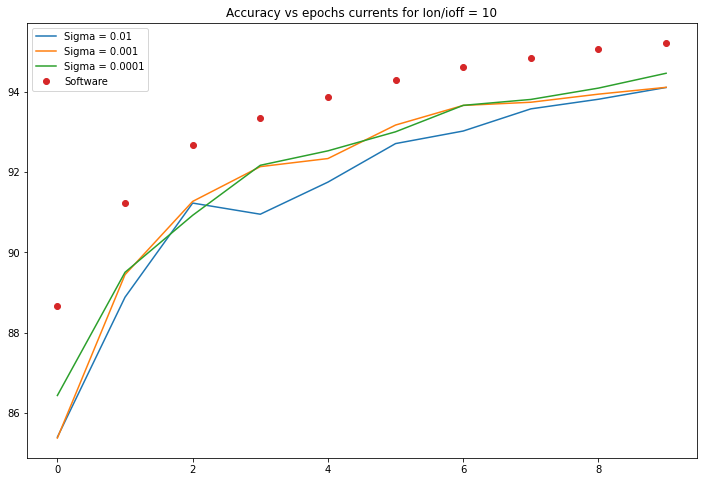

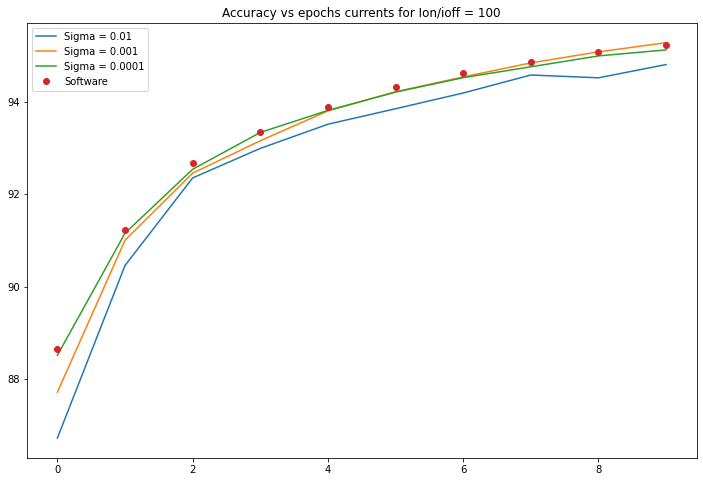

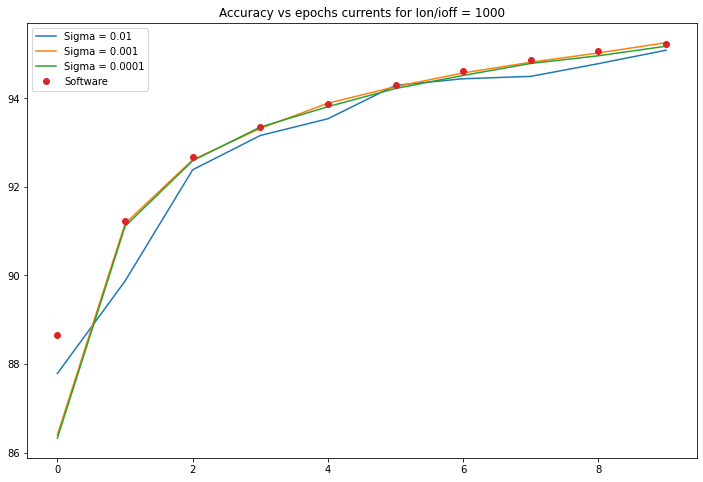

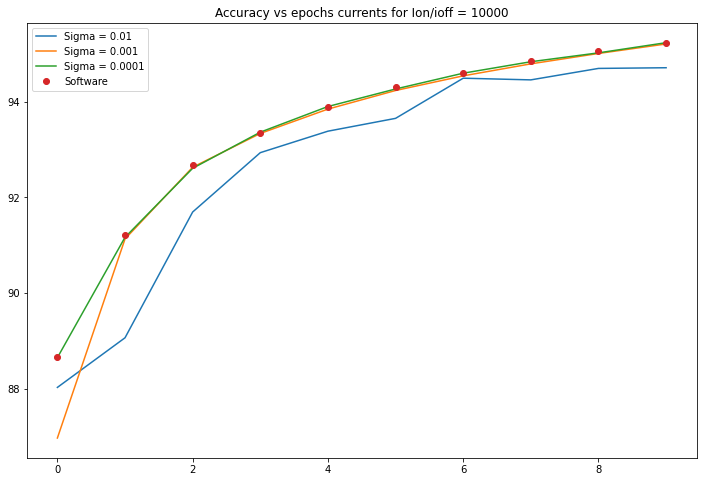

In [92]:
for ratio  in OnOffRatio:
    trainAccForRatio = AccDic[str(ratio)]
    plt.figure(figsize=(12, 8))
    leg = []
    for i in range(1, len(trainAccForRatio)):
        plt.plot(trainAccForRatio[i])
        leg.append(f"Sigma = {Sigma[i]}")
    plt.plot(tP, 'o')
    leg.append("Software")
    plt.legend(leg)
    plt.title(f"Accuracy vs epochs currents for Ion/ioff = {ratio}")
    plt.savefig(f"C:\\Users\\HP\\Downloads\\Acc_OnOff_{ratio}.png")